# MMLDT-CSET 2021
# Short Course 2: 
# Mechanistic Machine Learning for Engineering and Applied Science
# (4) Lab-1: Convolutional Neural Networks (CNNs) for Crack Detection

Instructors: Prof. J.S. Chen, Xiaolong He, Kristen Susuki (UC San Diego)

---

1. Data Preparation
2. CNN Architecture and Training
3. Crack Detection

# Import Libraries

In [1]:
# Python ≥ 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥ 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow.keras as keras
# from tensorflow import keras
assert tf.__version__ >= "2.0"

# Check number of available CPUs and GPUs
import multiprocessing
print("Number of GPUs Available: ", multiprocessing.cpu_count())
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Common imports
import numpy as np
import pandas as pd
import os
from random import shuffle, randint, sample
import random
import scipy.io as sio
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
random.seed(1)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Number of GPUs Available:  12
Number of GPUs Available:  1


Automatic pavement crack detection is a challenging task that has been researched for decades due to the complicated pavement conditions in real world. [Fan et al. (2018)](https://arxiv.org/pdf/1802.02208.pdf) [1] proposed an automatic crack detection approach based on CNN.

# 1. Data Preparation

- The data is obtained from a [public database](https://github.com/cuilimeng/CrackForest-dataset), which contains **118 RGB** images with a resolution of **320 x 480** pixels. 


- These images contain **noises** such as shadows, oil spots, water stains, and non-uniform illumination.  


- The input of the network are **patches** extracted from images based on **each specific pixel**, see an example in the below figure.
    - The figure shows the extracted patch centered on pixel $(x,y)$. 
    - $h$ is the distance between the patch edges and the patch center. $h=13$ was selected in this paper.
    - The size of the **input patch**: $(2h+1) \times (2h+1)$.
    - As the image has three color channels, the dimension of each input patch is <font color="red"> **(27 x 27 x 3)** </font>.

<img src = "images/extracted_patch.PNG" width = "500">


- According to the manually labeled **ground truth**, if the **center pixel** of the extracted patch is a **crack pixel**, the corresponding patch is a **positive sample** and vice versa.


- In a typical crack image, **non-crack pixels are a lot more than crack pixels**. For a classification task with **imbalanced samples**, the proportion of positive and negative samples has a great impact on the network performance.


- To modify the proportion and keep the samples uniform for training, **all positive samples are extracted first**. Then, **negative samples are extracted randomly according to the prescribed proportion**. Generally, the ratio of positive to negative samples is set to **1:3**.


- Below figure shows some **negative (left)** and **positive (right)** training patches extracted from the data set.

<img src = "images/negative_positive_samples.PNG" width = "400">


- **Symmetric padding** is applied to the boundaries of images so that every pixel have an associated **(27 x 27 x 3)** patch. Thus, each image (320 x 480) have **153,600 pixels** and therefore **153,600 patches (instances or samples)**. However, we will NOT use all patches for training since we need create a **balanced training set**, as explained above.


- Each **pixel intensity** is represented as a byte (0 to 255). We scale it to the **0-1 range**.

In [4]:
def get_shuffled(images,labels):
    """
        This function returns shuffled images and labels.
        
        params: 
            images: list, given images to be shuffled
            labels: list, given labels to be shuffled
        
        return:
            image_shuffled: list, shuffled images
            labels_shuffled: list, shuffled labels
    """
    num_img = len(images) # number of images
    range_num = list(range(num_img))
    for i in range(5):
        shuffle(range_num)

    image_shuffled, labels_shuffled = [],[]
    for i in range_num:
        image_shuffled.append(images[i])
        labels_shuffled.append(labels[i])

    return image_shuffled, labels_shuffled

In [5]:
# get_shuffled?

In [6]:
def get_patch(image, seg_mask, flag_shuffle=True, ratio=3, h=13, s=2):
    """
        This function returns patches extracted from images and 
        corresponding structured labels extracted from ground truth (labels of images). 
        The ratio of the number of negative patches to the number of 
        positive patches is prescribed by "ratio".
        
        params:
            image: np.array, given image
            seg_mask: np.array, ground truth (label) corresponding to the image
            flag_shuffle: bool, indicates whether extracted patches and labels are shuffled
            ratio: int, the ratio of the number of negative patches to 
                    the number of positive patches
            h: int, input patch size = [2h+1, 2h+1], with the pixel at the center
            s: int, output patch size = [2s+1, 2s+1], with the pixel at the center
            
        return:
            patches: list, a list of patches with size [2h+1, 2h+1, 3] extracted from the given image
            labels: list, a list of target structured labels with size [(2s+1)^2,] extracted from the given ground truth
    """
    
    indices_pos = np.where(seg_mask == 1) # indices of positive pixels
    indices_neg = np.where(seg_mask == 0) # indices of negative pixels
    
    patches, labels = [], [] # all patches and labels extracted from the given image
    m0,n0 = image.shape[:2]
    
    ## Padding      
    label_paddings = tf.constant([[s,s], [s,s]])
    seg_mask = tf.constant(seg_mask)
    seg_mask_pad = tf.pad(seg_mask, label_paddings, 'CONSTANT').numpy() # zero paddings to labels
    
    img_paddings = tf.constant([[h,h], [h,h], [0,0]])
    img_tensor = tf.constant(image)
    image_pad = tf.pad(img_tensor, img_paddings, 'SYMMETRIC').numpy() # symmetric paddings to images
    
    
    # Positive patches and labels
    count, length = 0, len(indices_pos[0])
    for i,ind in enumerate(indices_pos[0]):
        x,y = ind, indices_pos[1][i]
        assert(image_pad[x:x+2*h+1, y:y+2*h+1].shape == (27,27,3))
        patches.append(image_pad[x:x+2*h+1, y:y+2*h+1])
        labels.append(seg_mask_pad[x:x+2*s+1, y:y+2*s+1].flatten())
        count+=1
            
            
    # Negative patches and labels
    no_negs = ratio*len(patches) # number of negative patches
    count, length = 0, len(indices_neg[0])
    while count < no_negs:
        rand_int = randint(0, length)-1 # random index
        x, y = indices_neg[0][rand_int], indices_neg[1][rand_int]
        assert(image_pad[x:x+2*h+1, y:y+2*h+1].shape == (27,27,3))
        patches.append(image_pad[x:x+2*h+1, y:y+2*h+1])
        labels.append(seg_mask_pad[x:x+2*s+1, y:y+2*s+1].flatten())
        count+=1
        
        
    # Shuffle all patches and labels
    if flag_shuffle: 
        patches, labels = get_shuffled(patches, labels)
    
    return patches, labels

In [7]:
def load_data(image_path, label_path, file_id, flag_shuffle=True, ratio=3, h=13, s=2):
    """
        This function returns arrays that contains all patches
        extracted from images and corresponding labels extracted 
        from ground truth of all images with indices listed in "file_id"
        
        params:
            image_path: str, path to images
            label_path: str, path to ground truth (labels of images)
            file_id: list, a list of indices of images
            flag_shuffle: bool, indicates whether extracted patches and labels are shuffled
            ratio: int, the ratio of the number of negative patches to 
                    the number of positive patches
            h: int, input patch size = [2h+1, 2h+1], with the pixel at the center
            s: int, output patch size = [2s+1, 2s+1], with the pixel at the center
        
        return:
            all_patches: np.array, [num_patches, 2h+1, 2h+1, 3], all patches extracted from images with indices in file_id
            all_labels: np.array, [num_patches, (2s+1)^2], all structured label extracted from images with indices in file_id
    """
    
    label_files = os.listdir(label_path) # list of names of label files
    label_files_remained = [label_files[i] for i in file_id] # consider the instances prescribed in file_id   
    
    all_patches = np.empty((0,2*h+1,2*h+1,3))
    all_labels = np.empty((0,(2*s+1)**2))
    
    for label_file in label_files_remained: # loop over label_files
        image_file = label_file.split('.')[0]+'.jpg' # image file name
        img = mpimg.imread(os.path.join(image_path, image_file)) # load image data
        
        mat_contents = sio.loadmat(os.path.join(label_path, label_file)) # load corresponding label
        seg_mask = mat_contents['groundTruth'][0][0][0]
        seg_mask[seg_mask == 1] = 0
        seg_mask[seg_mask > 1] = 1
        
        # preprocess data to get input patches and structured labels
        patches, labels = get_patch(img, seg_mask, flag_shuffle=flag_shuffle, ratio=ratio, h=h, s=s) 
        all_patches = np.concatenate((all_patches, patches), axis = 0)
        all_labels = np.concatenate((all_labels, labels), axis = 0)
    
    return all_patches, all_labels

In [8]:
# Indices of trianing and testing instances
n_train = 20  # number of training samples
n_test = 5    # number of testing samples
all_id = np.arange(118) # indices of all samples
train_id = np.array(sample(all_id.tolist(),n_train)) # random samples for training
test_id = np.array(sample(all_id.tolist(),n_test))   # random samples for testing

print("File indices of Training instances: ", train_id+1)
print("File indices of Testing instances: ", test_id+1)

File indices of Training instances:  [ 18  73 109 103  98   9  33  16  64  58  61  84  49 101  27  13  63   4
 115 107]
File indices of Testing instances:  [50 56 78 98 99]


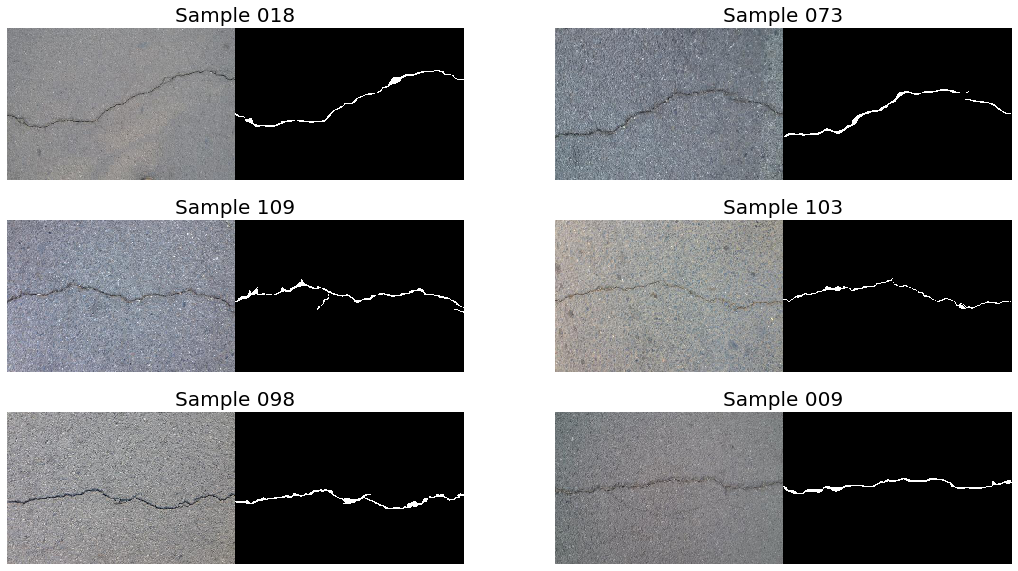

In [9]:
# Visualize images and ground truth in the Testing set
basepath = os.getcwd() # get the directory where the current notebook is located
label_path = os.path.join(basepath, 'data\\groundTruth') # the path to the ground truth folder
image_path = os.path.join(basepath, 'data\\image')       # the path to the image folder

label_files = os.listdir(label_path)
label_files_test = [label_files[i] for i in train_id[:6]]

fig = plt.figure(figsize=(18,10))
for i, label_file in enumerate(label_files_test):
    image_file = label_file.split('.')[0] + '.jpg' # image file name
    img = mpimg.imread(os.path.join(image_path, image_file)) / 255.0
    
    mat_contents = sio.loadmat(os.path.join(label_path, label_file))
    seg_mask = mat_contents['groundTruth'][0][0][0] # segmentation of ground truth is extracted; boundary is not used
    seg_mask[seg_mask == 1] = 0
    seg_mask[seg_mask > 1] = 1
    
    label_temp = np.zeros_like(img, dtype='int32')
    for j in range(3):
        label_temp[:,:,j] = seg_mask
    img_label = np.hstack([img, label_temp])
    
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(img_label)
    ax.axis('off')
    ax.set_title('Sample {}'.format(label_file.split('.')[0]), fontsize=20)
plt.savefig('images\\train_samples.png')

In [10]:
# Load training and testing sets
h = 13    # input patch size: [2h+1, 2h+1]
s = 2     # output patch size: [2s+1, 2s+1]
ratio = 3 # ratio of the number of negative samples to the number of positive samples

X_train, y_train = load_data(image_path, label_path, train_id, flag_shuffle=True, ratio=ratio, h=h, s=s)
X_test, y_test = load_data(image_path, label_path, test_id, flag_shuffle=False, ratio=ratio, h=h, s=s)
X_train /= 255.0
X_test /= 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(390692, 27, 27, 3) (390692, 25)
(33876, 27, 27, 3) (33876, 25)


# 2. CNN Architecture and Training

- The proposed CNN model [1] contains **4 convolutional layers** with **2 max-pooling layers** and **3 fully connected (FC) layers**, as shown in the below figure.

<img src = "images/crack_cnn_architecture.PNG" width = "800">


- All convolutional layers are equipped with a **kernel of 3 x 3** and a **stride of 1**. **Zeros padding** on the boundary of each convolutional layer is assigned to preserve the spatial resolution of resulting feature maps after convolution.


- **Max pooling** is performed with a **2 x 2 pool size** and a **stride of 2**.


- The output of the network is a <font color="red"> **prediction of the structured patch (size: $s_{out}$ x $s_{out}$) centered in the input patch** </font>. 
    - $s_{out}=5$ was used in the paper [1]. 
    - The $s_{out}$ x $s_{out}$ patch is flattened into $s_{out}^2$ neurons in the output layer of the network. 
    - There are $s_{out}^2$ **ground truth labels** for each input patch of an image.
    - Thus, the structured prediction problem is an <font color="red"> **multilabel binary classifivation** </font> problem.
    - If $s_{out}=1$, it becomes a single pixel **binary classification** problem.
    - A parameter $s$ is used to denote the number of pixels between the centered pixel and the boundary of the output patches. Thus, <font color="red"> $s_{out} = 2s + 1$ </font>


- **Activation** functions:
    - Output layer: **sigmoid**
    - All hidden layers: **ReLU**
    

- **Loss** function: **cross entroy** is applied.


- **Regularization**: control model flexibility to avoid overfitting
    - **$L_2$ penalty** on connection weights is added to the loss function with a penalty coefficient of 0.0005.
    - **Dropout** is applied to the first two FC layers with a dropout ratio of 0.5

In [11]:
# Set Hyperparameters and Paths 
savedir = os.path.join(basepath, 'trained_model') # directory for saving the trained model
lr = 1e-3        # learning rate
epoch = 10       # number of training epochs
batch_size = 256 # batch size

In this demonstration, our CNN model contains 
- 3 convolutional layer with a kernel of 2 x 2, a stride of 1, and zero padding
- 1 max pooling layer with a 2 x 2 pool size
- 3 fully connected layers with 64, 64 and 25 neurons respectively
- ReLU activation is used in all hidden layers
- Sigmoid activation is used in the output layer
- Cross entropy loss is used

In [12]:
def model(h=13, s=2):
    """
        This function creates a CNN model.
        
        params: 
            h: int, input patch: [2h+1, 2h+1], with the pixel at the center
            s: int, output patch: [2s+1, 2s+1], with the pixel at the center
        
        return:
            model: tf.keras.sequential
    """
    model = keras.models.Sequential()
    
    # 1st Convolutional Layer: 16 feature maps, kernel size: 3x3, stride: 1, padding: zeros
    model.add(keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='same', activation='relu', 
                                  input_shape=[2*h+1,2*h+1,3]))
    
    # 2nd Convolutional Layer: 32 feature maps, kernel size: 3x3, stride: 1, padding: zeros
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    
    # 3rd Convolutional Layer: 64 feature maps, kernel size: 3x3, stride: 1, padding: zeros
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    
    # Max Pooling Layer: window size: 2x2, stride: 2
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense((2*s+1)**2, activation='sigmoid'))
    return model

In [13]:
# Instantiate and Compile a CNN model   
cnn = model(h=h, s=s)
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [14]:
# Train CNN; Use 20% training data as the validation set
history = cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epoch, validation_split=0.2)

Epoch 1/10
1221/1221 [==============================] - 44s 36ms/step - loss: 0.4412 - binary_accuracy: 0.7934 - val_loss: 0.2814 - val_binary_accuracy: 0.8621
Epoch 2/10
1221/1221 [==============================] - 44s 36ms/step - loss: 0.3423 - binary_accuracy: 0.8451 - val_loss: 0.2526 - val_binary_accuracy: 0.8870
Epoch 3/10
1221/1221 [==============================] - 44s 36ms/step - loss: 0.2453 - binary_accuracy: 0.8974 - val_loss: 0.2241 - val_binary_accuracy: 0.9035
Epoch 4/10
1221/1221 [==============================] - 43s 35ms/step - loss: 0.1597 - binary_accuracy: 0.9331 - val_loss: 0.2265 - val_binary_accuracy: 0.9080
Epoch 5/10
1221/1221 [==============================] - 58s 48ms/step - loss: 0.1226 - binary_accuracy: 0.9474 - val_loss: 0.2092 - val_binary_accuracy: 0.9199
Epoch 6/10
1221/1221 [==============================] - 43s 35ms/step - loss: 0.1033 - binary_accuracy: 0.9553 - val_loss: 0.2157 - val_binary_accuracy: 0.9246
Epoch 7/10
1221/1221 [==================

In [15]:
# Save the trained model
trained_model = 'trained_'+ 'adam' + '_s_out' + str(2*s+1) + '.h5'
cnn.save(os.path.join(savedir, trained_model))

Saving figure Learning Curves


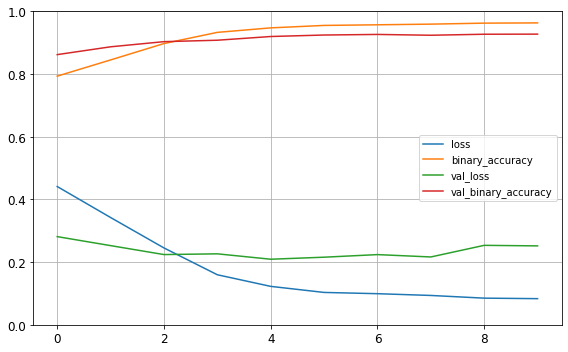

In [16]:
# Plot Learning Curves (hisotry of training and validation loss)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("Learning Curves")
plt.show()

In [17]:
# Evaluate the trained model on the Testing set
test_eval = cnn.evaluate(X_test, y_test)
print("\n Test loss: {:.8f}    Test accuracy: {:.8f}".format(test_eval[0], test_eval[1]))

1059/1059 [==============================] - 4s 3ms/step - loss: 0.2928 - binary_accuracy: 0.9157

 Test loss: 0.29279202    Test accuracy: 0.91572696


# 3. Crack Detection

<img src = "images/CNN_structured_prediction.PNG" width = "900">

- (a) Two pixels of the an image. $(x_1, y_1)$, $(x_2, y_2)$ are the coordinates of the pixels.
- (b) The extracted patches centered on the pixels. The size of the patches is 27 × 27.
- (c) The structured predictions of CNN given the input patches shown in (b). 
- (d) The probability map obtained by applying structured prediction on all pixels.


- In testing, each pixel is used for generating an input patch, so **input patches overlap**, leading to **overlap of output patches ($s_{out}$ x $s_{out}$)**. The center coordinates of these output patches are the corresponding pixel coordiantes.


- Each pixel in a testing image has $s_{out}$ x $s_{out}$ predictions except that it is near the boundary. Then, for a testing image, predictions of all pixels are **summed and normalized to [0,1]**. As a result, we can obtain a **probability map** of an image, indicating the **probability of pixels being cracked**.
    - Note: **symmetric padding** is applied to boundaries of testing images


- Applying a **decision threshold**, we can obtain the final **crack classification of all pixels** of an image.

The performance of the network on test images is evaluted by **precision**, **recall**, and **F1 score (F1)**, which are commonly used in classification problems.

$$ Precision = \frac{TP}{TP + FP} $$

$$ Recall = \frac{TP}{TP + FN} $$

$$ F1 = \frac{2 \times Precision \times Recall}{Precision + Recall} $$

where $TP$, $FP$, $FN$ are the numbers of **true positive**, **false negative**, and **false negative**, respectively.

In [18]:
def get_batches(image, h=13):
    """
        This function extract patches from the given image with 
        the patch size being [2h+1, 2h+1].
        
        params:
            image, np.arrays, given image
            h: int, input patch size: [2h+1, 2h+1], with the pixel at the center
            
        return:
            patches: np.arrays, extracted patches from the given image
    """
    m,n,p = image.shape
    patches = []
    for i in range(0,m):
        for j in range(0,n):
            if i-h-1 < 0 or j-h-1 < 0 or i+h+1 > m or j+h+1 > n:
                continue
            else:
                patches.append(image[i-h:i+h+1, j-h:j+h+1])
    return np.array(patches)


def infer(prediction, m, n, h=13, s=2):
    """
        This function sums up the structured outputs from s_out^2 units of 
        all pixels in an image. Note that the structured outputs of pixels
        can overlap.
        
        params:
            prediction: [num_pixels, num_output_units]
                        predictions from all s_out^2 output units of each pixel
            m: number of pixels in horizontal direction of original image
            n: number of pixels in vertical direction of original image
            h: int, input patch size: [2h+1, 2h+1], with the pixel at the center
            s: int, output patch size: [2s+1, 2s+1], with the pixel at the center
            
        return:
            array of image's original size that contains aggregate predictions
    """
    out = np.zeros((m,n), np.float32)
    count = 0
    for i in range(0,m):
        for j in range(0,n):
            if i-h-1 < 0 or j-h-1 < 0 or i+h+1 > m or j+h+1 > n:
                continue
            else:
                out[i-s:i+s+1,j-s:j+s+1] += prediction[count].reshape((2*s+1,2*s+1))
                count+=1
    return out[h:m-h,h:n-h]


def save_output(img, image_file, label, out_norm, save_path):
    """
        This function plots and saves figures: 
        original image, label, crack prediction image
        
        params:
            img: np.arrays, original image
            image_file: str, file name of the given image
            label: np.arrays, label of the original image
            out_norm: crack classification results
            save_path: path to save prediction images
    """
    out_channels = np.zeros_like(img)
    label_temp = np.zeros_like(img, dtype='int32')
    for i in range(3):
        out_channels[:,:,i] = out_norm
        label_temp[:,:,i] = label
        
    white_space = np.ones((img.shape[0],10,3), dtype='int32')
    save_image = np.hstack([img, white_space, label_temp, white_space, out_channels]) # stack arrays in sequence horizontally
    plt.figure(figsize=(18,6))
    plt.imshow(save_image)
    plt.axis("off")
    plt.savefig(os.path.join(save_path, image_file.replace('jpg','png')))
    plt.show()


def calc_precision_recall(ytrue, ypred):
    """
        This function calculates precision, recall, and F1 score.
        
        params:
            ytrue: np.arrays, ground truth
            ypred: np.arrays, model prediction
        
        return:
            precision: float
            recall: float
            F1 score: float
    """
    true_pos = len(np.nonzero(np.logical_and(ytrue==ypred, ytrue==1))[0])
    true_neg = len(np.nonzero(np.logical_and(ytrue==ypred, ytrue==0))[0])
    false_pos = len(np.nonzero(np.logical_and(ytrue!=ypred, ytrue==1))[0])
    false_neg = len(np.nonzero(np.logical_and(ytrue!=ypred, ytrue==0))[0])
    
    precision = float(true_pos) / (true_pos+false_pos)
    recall = float(true_pos) / (true_pos+false_neg)
    F1 = float(2*precision*recall) / (precision+recall)
    
    return precision, recall, F1

In [21]:
def crack_pred(model, label_path, image_path, save_path, test_id, h=13, s=2):
    """
        This function uses the trained CNN model to perform crack prediction on testing samples.
        It plots and saves figures: original image + ground truth + crack prediction image
        
        params:
            model: tf.keras.sequential, the trained CNN model
            label_path: str, path to the ground truth
            image_path: str, path to the images
            save_path: str, path to save prediction images
            test_id: list, indices of testing instances
            h: int, input patch size: [2h+1, 2h+1]
            s: int, output patch size: [2s+1, 2s+1]
            
        return:
            precision: float, precision score of testing set
            recall: float, recall score of testing set
            F1: float, F1_score of testing set
    """
    label_files = os.listdir(label_path) # list of names of label files
    
    label_files_remained = [label_files[i] for i in test_id] # consider the instances prescribed in file_id
    paddings = tf.constant([[h,h], [h,h], [0,0]])

    tot_p, tot_r, tot_f = 0, 0, 0
    count = 0
    for label_file in label_files_remained:
        # Load the image of Test instance
        image_file = label_file.split('.')[0] + '.jpg'
        img = mpimg.imread(os.path.join(image_path, image_file)) / 255.0

        # Symmetric padding
        img_tensor = tf.constant(img)
        img1 = tf.pad(img_tensor, paddings, 'symmetric').numpy()
        m,n,p = img1.shape
        X_test = get_batches(img1) # patches extracted from an image

        # Load the label of Test instance
        mat_contents = sio.loadmat(os.path.join(label_path, label_file))
        seg_mask = mat_contents['groundTruth'][0][0][0]
        seg_mask[seg_mask == 1] = 0
        seg_mask[seg_mask > 1] = 1

        # Prediciton Results of Test instance
        total_prediction = model.predict(X_test)

        # Probability Map
        out = infer(total_prediction, m, n, h=h, s=s)
        out_norm = np.zeros_like(out)
        out_norm = cv2.normalize(out, out_norm, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # show(out_norm)

        # Crack prediction: decision threshold = 0.5
        # predicted probability >= 0.5, it is a Crack pixel
        # predicted probability < 0.5, it is a Non-Crack pixel
        out_norm[out_norm >= 0.5] = 1
        out_norm[out_norm < 0.5] = 0
        # show(out_norm)

        # Save figures
        save_output(img, image_file, seg_mask, out_norm, save_path)
        precision, recall, F1 = calc_precision_recall(seg_mask, out_norm)
        tot_p += precision 
        tot_r += recall
        tot_f += F1
        count += 1
    #     print(tot_p, tot_r, tot_f)
    
    precision = tot_p/count
    recall = tot_r/count
    f1 = tot_f/count

    return precision, recall, f1

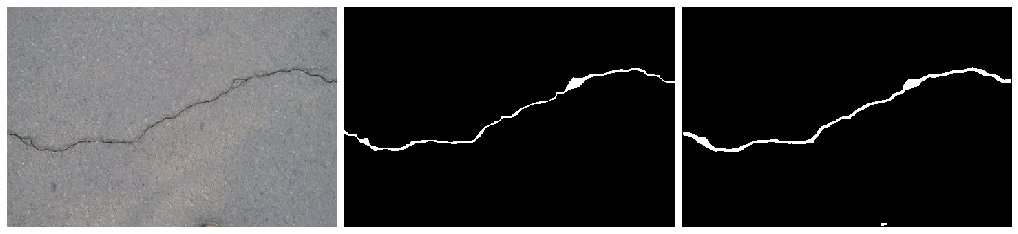

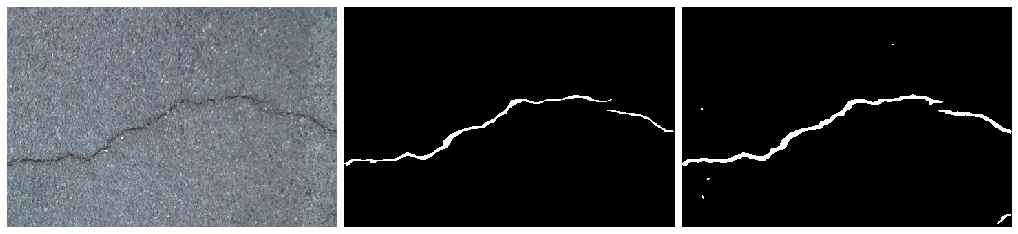

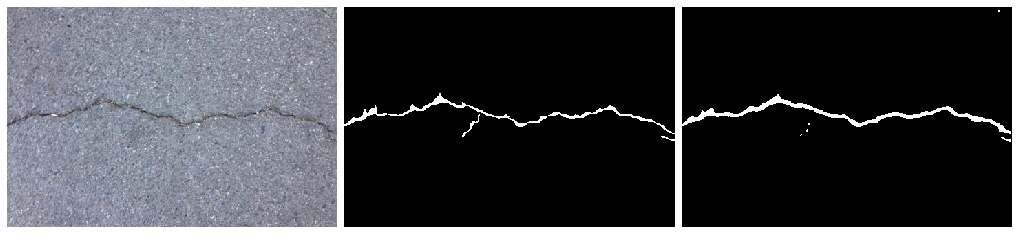

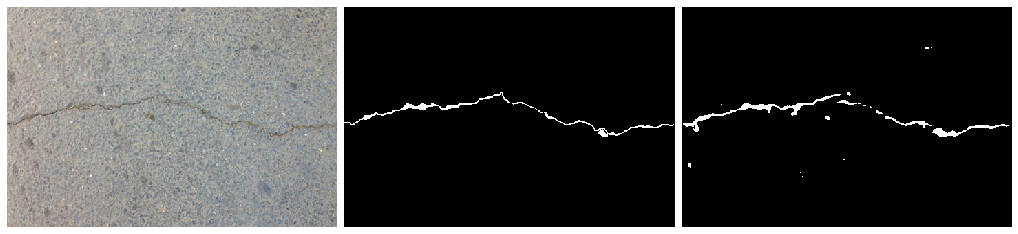

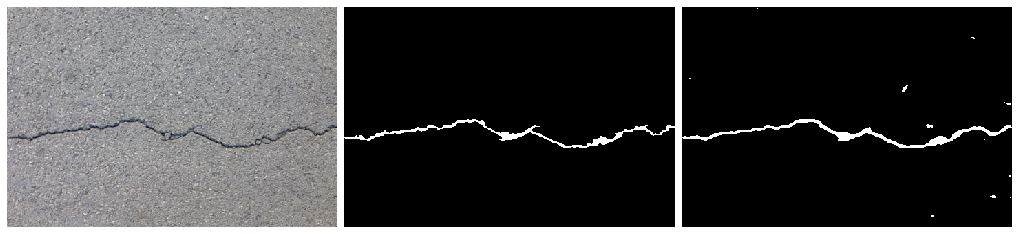

In [22]:
# Crack prediction on first 5 samples in the Training set by the trained model
save_path = os.path.join(basepath, 'prediction', 'train')
precision, recall, f1 = crack_pred(cnn, label_path, image_path, save_path, train_id[:5], h=h, s=s)

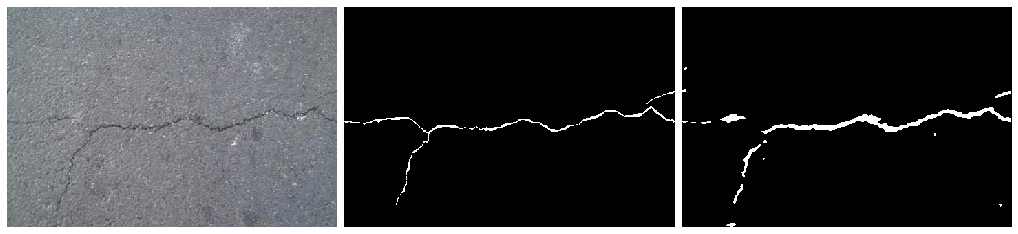

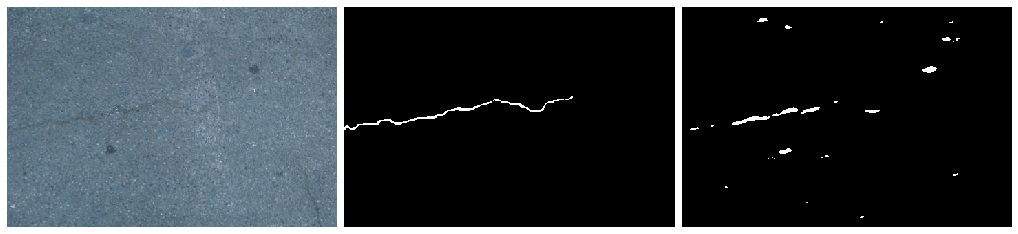

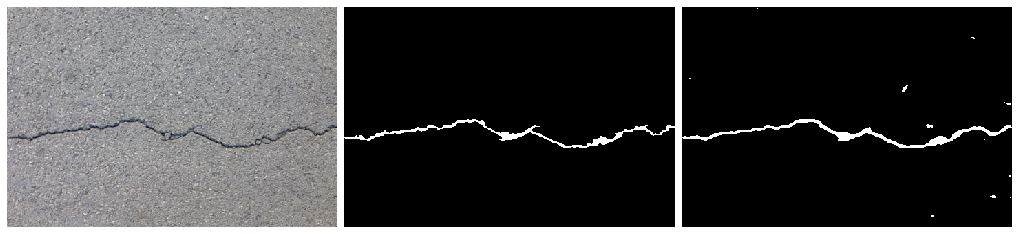

Average Precision:0.72037625
Average Recall:   0.47508965
Average F1_score: 0.55998094


In [23]:
# Crack prediction on Testing set by the trained model
save_path = os.path.join(basepath, 'prediction', 'test')
precision, recall, f1 = crack_pred(cnn, label_path, image_path, save_path, test_id, h=h, s=s)

print("Average Precision:{:0.8f}".format(precision))
print("Average Recall:   {:0.8f}".format(recall))
print("Average F1_score: {:0.8f}".format(f1))

# References

1. Fan, Z., Wu, Y., Lu, J., & Li, W. (2018). Automatic pavement crack detection based on structured prediction with the convolutional neural network. arXiv preprint arXiv:1802.02208.